# Import the required packages

In [9]:
#Taken From:https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
from pprint import pprint
import numpy as np
import os
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# Import the dataset


In [10]:
docs=[]
path='D:/UN/UNGDC_1970-2017/Converted sessions'
for (dirname, dirs, files) in os.walk(path):
   for filename in files:
        thefile = os.path.join(dirname,filename)
        with open (thefile,encoding='utf8',errors='ignore') as fin:
            doc=fin.read().strip('\n\t')
            docs.append(doc)       
print(len(docs))

7904


# Define a function for tokenizing and lemmatizing

In [11]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
docs = docs_preprocessor(docs)


# Create Biagram & Trigram Models 

In [12]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a trigram, add to document.
            docs[idx].append(token)


# Remove rare & common tokens 

In [13]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 41247
Number of documents: 7904


# Build The Model

In [14]:
# Set parameters.
num_topics = 5
chunksize = 500 
passes = 20 
iterations = 400
eval_every = 1  

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.010*"soviet_union" + 0.008*"file" + 0.006*"text" + 0.005*"name" + 0.005*"central_asia" + 0.004*"foreign_policy" + 0.004*"ukraine" + 0.004*"republic_moldova" + 0.004*"corpus" + 0.003*"azerbaijan"'), (1, '0.005*"central_african" + 0.004*"third_world" + 0.004*"democratic_republic" + 0.003*"guinea_bissau" + 0.003*"south_african" + 0.003*"western_sahara" + 0.002*"african_unity" + 0.002*"industrialized_country" + 0.002*"african_continent" + 0.002*"great_lake"'), (2, '0.002*"young_people" + 0.002*"central_america" + 0.002*"latin_american" + 0.002*"rather_than" + 0.001*"united_kingdom" + 0.001*"young" + 0.001*"this_hall" + 0.001*"twenty_first" + 0.001*"caribbean" + 0.001*"drug_trafficking"'), (3, '0.005*"syria" + 0.004*"republic_korea" + 0.004*"syrian" + 0.004*"islamic" + 0.003*"libya" + 0.003*"islamic_republic" + 0.003*"call_upon" + 0.003*"iraqi" + 0.002*"weapon_mass" + 0.002*"sudan"'), (4, '0.005*"european_union" + 0.004*"small_island" + 0.003*"african_union" + 0.003*"millennium_deve

# Find the optimal number of topics

In [15]:
#Using c_v Measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Create a model list and plot Coherence score against a number of topics

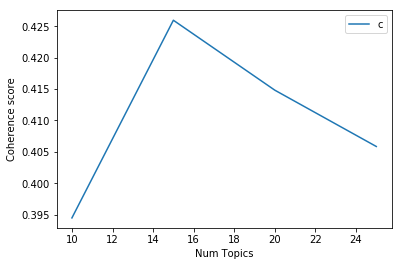

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=10, limit=30, step=5)
# Show graph
import matplotlib.pyplot as plt
limit=30; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3945
Num Topics = 15  has Coherence Value of 0.426
Num Topics = 20  has Coherence Value of 0.4148
Num Topics = 25  has Coherence Value of 0.4059


# Selecting The Optimal Model

In [18]:
#finding the number of topics that gives the highest Coherence Value 
max_cv=max(coherence_values)
#finding the index of the model with this numnber of topics
index_model=coherence_values.index(max_cv)
#print(index_model)
# Select the model and print the topics 
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

# Writing the topics along with the 10 most frequent words in a file

In [19]:
import re
with open('D:/UN/Topics_UN.csv','w') as fw:
    fw.write("topic_id,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9"+"\n")
    for i in optimal_model.print_topics():
        r1 = re.findall(r"\w+",i[1])
        line=str(i[0])
        for item in r1:
            if not item.isdigit():
                line=line+','+item
        fw.write(line+'\n')

# Displaying the file

In [20]:
from IPython.display import display
import pandas
df = pandas.read_csv("D:/UN/Topics_UN.csv")
display(df)

,topic_id,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9
0,0,cyprus,turkey,turkish_cypriot,turkish,cypriot,european_union,greece,greek_cypriot,greek,peaceful_settlement
1,1,file,text,name,corpus,format,matrix,general_debate,data,write,dominican_republic
2,2,ireland,soviet_union,northern_ireland,peace_keeping,central_america,third_world,party_concerned,south_african,defeat_terrorism,east_west
3,3,republic_korea,korean_peninsula,saint_kitts,korean,soviet_union,peninsula,cuba,north_korea,yemen,republic_yemen
4,4,millennium_development,antigua_barbuda,twenty_first,responsibility_protect,civil_society,european_union,natural_disaster,drug_trafficking,around_world,natural_resource
5,5,syria,australia,chemical_weapon,united_kingdom,state_qatar,spain,call_upon,egypt,weapon_mass,african_union
6,6,european_union,peace_keeping,mongolia,foreign_policy,syrian_people,japan,soviet_union,bulgaria,republic_korea,albania
7,7,european_union,trinidad_tobago,good_governance,armed_conflict,globalization,costa_rica,mali,great_lake,criminal_court,millennium_development
8,8,central_asia,ukraine,pakistan,kazakhstan,foreign_policy,afghan,soviet_union,central_asian,viet,india
9,9,central_america,central_american,latin_american,panama,honduras,young_people,guatemala,third_world,bolivia,peace_keeping


# The file is fed to the paper's model and the Labels are as follows

In [21]:
#The Labels are saved into a file named output_unsupervised.txt
#The following code changes the file into CSV format to be shown here
with open("d:/UN/output_unsupervised.txt") as fi:
    content=fi.read().strip().split("top 3 labels for topic")

with open ("d:/UN/Labels","w") as fw:
    fw.write("Topic_id,Label_1,Label_2,Label_3"+'\n')
    Topic_id=0
    for i in content:
       i=i.split('\n')
       if len(i)>3:         
         fw.write(str(Topic_id)+','+i[1]+','+i[2]+','+i[3]+'\n')
         Topic_id+=1
    
df = pandas.read_csv("d:/UN/Labels")
display(df)

,Topic_id,Label_1,Label_2,Label_3
0,0,el_salvador,central_america,korea
1,1,african_union,southern_african_development_community,international_development
2,2,international_relations,international_development,peacebuilding
3,3,pacific_ocean,greater_antilles,caribbean_sea
4,4,europe,southeast_asia,guatemala
5,5,egypt,syrian_civil_war,tunisia
6,6,angola,liberia,bolivia
7,7,eastern_europe,baltic_states,kyrgyzstan
8,8,soviet_central_asia,central_asia,kazakhstan
9,9,africa,cameroon,south_africa
